In [3]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt
import warnings
from scipy.optimize import approx_fprime
import xarray as xr
try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM
from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions
from scipy.optimize import minimize

/tmp/ipykernel_4047174/307742651.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
def to_df(cscm):
    """Convert the results of a CICEROSCM object to a DataFrame"""
    out=pd.concat([pd.DataFrame(v) for k, v in cscm.results.items()], axis = 1, keys = list(cscm.results.keys()))
    return out

def calc_beta(mol_mass):
    """Calculate the beta value for a given molecular mass"""
    return 1.7758620689655172e8 * mol_mass * 1e-9

def check_hfc(species):
    """Check if the species is an HFC and remove the hyphen"""
    if "HFC-" in species:
        sp_in = species.replace("-", "")
    else:
        sp_in = species
    return sp_in

def agage_emissions(species):
    """Read AGAGE emissions data for a given species"""
    py_path = f"/user/home/lw13938/work/py12box_agage/data/{species}/outputs/{species}_Global_annual_emissions.csv"
    em_csv = pd.read_csv(py_path, comment="#",index_col=False)
    index = em_csv['Decimal_date'].values.astype(int)
    data = em_csv['Global_annual_emissions'].values
    data[data < 0.] = 0.0
    sp_in = check_hfc(species)
    df = pd.DataFrame(index=index, data=data)
    df.index.name = "Component"
    df.columns = [sp_in]
    return df

def agage_mf(species):
    """Read AGAGE mole fractions data for a given species"""
    py_path = f"/user/home/lw13938/work/py12box_agage/data/{species}/outputs/{species}_Global_annual_mole_fraction.csv"
    mf_csv = pd.read_csv(py_path, comment="#",index_col=False)
    index = mf_csv['Decimal_date'].values.astype(int)
    data = mf_csv['Global_annual_mole_fraction'].values
    sp_in = check_hfc(species)
    df = pd.DataFrame(index=index, data=data)
    df.index.name = "Component"
    df.columns = [sp_in]
    return df

def zero_mf(species):
    """Create a DataFrame of zeros for a given species"""
    sp_in = check_hfc(species)
    dfc = pd.DataFrame(index=emi_input.index, columns=[sp_in], data=0)
    dfc.index.name = "Component"
    return dfc

def run_ciceroscm(gaspam_in, emi_input_in, df_ssp2_conc_in, conc_run=False):
    # NBVAL_IGNORE_OUTPUT
    scen = 'test'
    cscm_dir=CICEROSCM({
                "gaspam_data": gaspam_in,
                "emstart": 1750,  
                "conc_run":conc_run,
                "nystart": 1750,
                "nyend": 2024,
                "concentrations_data": df_ssp2_conc_in,
                "emissions_data": emi_input_in,
                "nat_ch4_data": df_nat_ch4,
                "nat_n2o_data": df_nat_n2o,
                "idtm":24,
            })

    # NBVAL_IGNORE_OUTPUT
    cscm_dir._run({
                "results_as_dict":True
            },
        pamset_udm={"threstemp": 7.0, #scales vertical velocity as a function of mixed layer temperature
                        "rlamdo":16.0,#air-sea heat exchange coefficient (wm^-2K^-1)
                        "akapa":0.634, #vertical heat diffusivity
                        "cpi":0.4, #temperature change ratio: polar to nonpolar region
                        "W":4, #vertical velocity (m/yr)
                        "beto":3.5, #ocean interhemispheric heat exchange coeff (Wm^-2K^-1)
                        "lambda":0.54,
                        "mixed":60.0,  #mixed layer depth
                        "foan":0.61, #fraction of northern hemisphere covered by ocean
                        "foas":0.81, #fraction of northern hemisphere covered by ocean
                        "ebbeta":0.0,#atmospheric interhemispheric heat exchange 
                        "fnso":0.7531, #ocean area ratio, northern to southern hemisphere
                        "lm":40, #number of vertical layers
                        "ldtime":12,
                    },
        pamset_emiconc={"lamb": 0.8,
                        "qbmb":0.03,
                        "qo3":0.4,
                        "qdirso2":-.457,
                        "qindso2":-.514,
                        "qbc":.2,
                        "qh2o_ch4":.171,
                        "qoc":-.103,
                        "ref_yr":2010,
                        "idtm":24})
    df_temp = to_df(cscm_dir)
    return df_temp

test_data_dir = "/user/home/lw13938/work/ciceroscm/tests/test-data/"

# Read gas parameters
gaspam =read_components(test_data_dir + '/gases_v1RCMIP.txt')
df_nat_ch4 =read_natural_emissions(test_data_dir + '/natemis_ch4.txt','CH4')
df_nat_n2o =read_natural_emissions(test_data_dir + '/natemis_n2o.txt','N2O')

df_ssp2_conc =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
emi_input =read_inputfile(test_data_dir + '/ssp245_em_RCMIP.txt')
emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)

/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_gas = pd.read_csv(filename, delim_whitespace=True, index_col=0)
/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:98: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_input = pd.read_csv(
/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:98: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_input = pd.read_csv(


In [5]:
emi_input_in = emi_input.copy()
df_ssp2_conc_in = df_ssp2_conc.copy()
df_out = run_ciceroscm(gaspam, emi_input_in, df_ssp2_conc_in, conc_run=True)


In [6]:
# plt.plot(df_out['forcing']['STRAT_O3'].dropna())
# plt.plot(df_out['forcing']['TROP_O3'].dropna())
# plt.plot(df_out['forcing']['STRAT_O3'].dropna()+df_out['forcing']['TROP_O3'].dropna(),"k:")
# plt.xlim(1920,2010)
# df_out['forcing'].keys()

In [7]:
def get_ncl(species, ebr=60):
    """Get the number of ECl per molecule"""
    if species == "PCE":
        species = "C2Cl4"
    if "CFC-" in species:
        num = species.split("-")[-1]
        if len(num) > 2:
            a = num[0]
            b = num[1]
            c = num[2]
        else:
            a = str(0)
            b = num[0]
            c = num[1]
        def_ = str(90 + int(a + b + c))
        ncl = 2*int(def_[0]) + 2 - int(def_[1]) - int(def_[2]) 
    elif "H-" in species:
        num = species.split("-")[-1]
        ncl = int(num[-1])*ebr + int(num[-2])
    elif "Cl" in species:
        cl = species.split("Cl")[-1]
        if cl == "":
            ncl = 1
        else:
            ncl = int(cl[0])
    elif "Br" in species:
        br = species.split("Br")[-1]
        if br == "":
            ncl = ebr
        else:
            ncl = int(br[0])*ebr
    else: 
        ncl = 0
    return ncl

EESC_dict_frf_ml_E19 = {
    'CFC-11': 0.47,
    'CFC-12': 0.24,
    'CFC-113': 0.30,
    'CFC-114': 0.13,
    'CFC-115': 0.07,
    'CCl4': 0.56,
    'CH3CCl3': 0.61,
    'HCFC-22': 0.15,
    'HCFC-141b': 0.34,
    'HCFC-142b': 0.17,
    'HCFC-123':0.66,
    'H-1211': 0.65,
    'H-1202': 0.67,
    'H-1301': 0.32,
    'H-2402': 0.66,
    'CH3Br': 0.6,
    'CH3Cl': 0.44,
    'CFC-112': 0.3,
    'CFC-113a': 0.29
}

cmip6_data = {
    "years" : [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2007, 2010],
    "CNRM-CM6-1": [-0.01, -0.01, -0.01, -0.02, -0.02, 0.00, -0.02, -0.05, -0.08, -0.09, -0.09],
    "CNRM-ESM2-1": [0.04, 0.04, 0.04, 0.04, 0.02, 0.03, -0.02, -0.09, -0.13, -0.12, -0.12],
    "UKESM1-0-LL": [0.04, 0.05, 0.08, 0.08, 0.10, 0.11, 0.06, 0.00, -0.06, -0.07, -0.06],
}




/tmp/ipykernel_4047174/1244776164.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0068302442249781' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  EESC.loc[yr, sp] = df_ssp2_conc.loc[yr-3,sp]*EESC_dict_frf_ml_E19[sp]*get_ncl(sp)
/tmp/ipykernel_4047174/1244776164.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.009328155331296' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  EESC.loc[yr, sp] = df_ssp2_conc.loc[yr-3,sp]*EESC_dict_frf_ml_E19[sp]*get_ncl(sp)
/tmp/ipykernel_4047174/1244776164.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.001183497608871' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  EESC

(800.0, 2000.0)

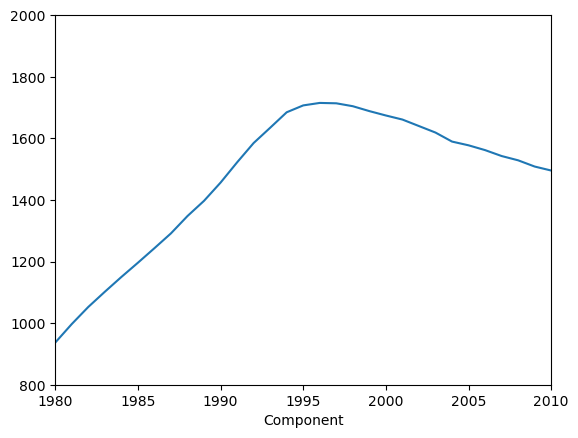

In [8]:
EESC = pd.DataFrame(0, index=df_ssp2_conc.index, columns=df_ssp2_conc.columns)
for sp in df_ssp2_conc_in.keys():
    if "CFC" in sp or "Cl" in sp or "Br" in sp or "H-" in sp:
        if sp == "HCFC-123":
            continue
        for yr in df_ssp2_conc.index[3:]:
            EESC.loc[yr, sp] = df_ssp2_conc.loc[yr-3,sp]*EESC_dict_frf_ml_E19[sp]*get_ncl(sp)

EESC.sum(axis=1).plot()
plt.xlim(1980,2010)
plt.ylim(800,2000)

/tmp/ipykernel_4047174/1682528399.py:45: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(min_func, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})


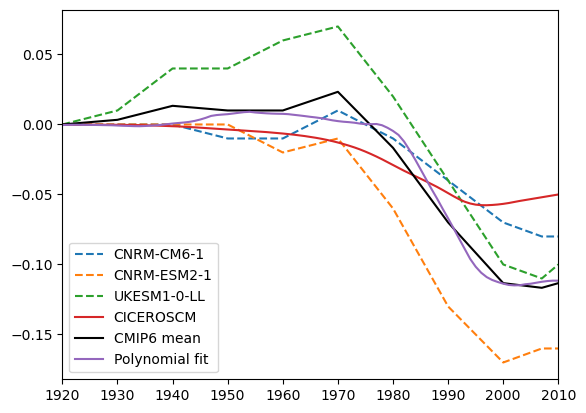

In [9]:

for key in cmip6_data.keys():
    if key == "years":
        continue
    plt.plot(cmip6_data["years"], np.array(cmip6_data[key])-cmip6_data[key][0], label=key, linestyle='--')

# Plot mean of cmip6_data
cmip6_df = pd.DataFrame(cmip6_data)
cmip6_df.set_index("years", inplace=True)
# cmip6_df.mean(axis=1).plot(label="CMIP6 mean", color="black")

# Interpolate cmip6 data to match EESC
cmip6_df_interp = cmip6_df.reindex(EESC.index).interpolate()
# Mean scaling between EESC and CMIP6
scale = (cmip6_df_interp.mean(axis=1).loc['1960':'2010'].mean()/EESC.sum(axis=1).loc['1960':'2010']).mean()

# scale = (df_out['forcing']['STRAT_O3'].dropna().loc['1980':'2024']/EESC.sum(axis=1).loc['1980':'2024']).mean()
plt.plot(df_out['forcing']['STRAT_O3'].dropna(), label="CICEROSCM")
# (scale*EESC.sum(axis=1)).plot(label="EESC scaled")


eesc = (EESC.sum(axis=1)-EESC.loc[1750].sum()).loc['1920':'2010'].values
y = cmip6_df_interp.mean(axis=1).loc['1920':'2010'].values - cmip6_df_interp.mean(axis=1).loc[1920]
plt.plot(EESC.loc['1920':'2010'].index, y, label="CMIP6 mean", color="black")

# New minimisation function where eesc is fit to a polynomial
def running_mean(x, window_size):
    half_window = window_size // 2
    # Reflect padding for boundary handling
    if window_size % 2 == 0:
        x_padded = np.pad(x, (half_window-1, half_window), mode='reflect')
    else:
        x_padded = np.pad(x, (half_window, half_window), mode='reflect')
    # Create the window for averaging
    window = np.ones(window_size) / window_size
    # Convolve and return only the part that matches the input size
    return np.convolve(x_padded, window, mode='valid')
def sarffun(x):
    return x[0]*eesc*1e-8 + x[1]*1e-8*(eesc)**2 + x[2]*1e-8*running_mean(eesc, 24)
def min_func(x):
    mod = sarffun(x)
    return np.sum((mod - y)**2)
 
x0 = np.array([1, 1, 1])
# x0 = np.array([1, 1,1,1])
res = minimize(min_func, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})

# plt.plot(EESC.loc['1920':'2010'].index, res.x[0] + res.x[1]*eesc*1e-8 + res.x[2]*(eesc*1e-8)**2, label="Polynomial fit")
# plt.plot(EESC.loc['1920':'2010'].index, res.x[0]*eesc*1e-8 + res.x[1]*1e-8*(eesc)**2, label="Polynomial fit")
plt.plot(EESC.loc['1920':'2010'].index, sarffun(res.x), label="Polynomial fit")

plt.xlim(1920,2010)
plt.legend()


In [10]:
# def inv_gaussian(age_x, mean_age=3.):
#     width = mean_age/2.
#     return (2 * width * np.sqrt( np.pi * (age_x/mean_age)**3))**-1 * \
#         np.exp(-mean_age**2 * (age_x/mean_age - 1)**2 / (4 * width**2 * (age_x/mean_age)))

weights = np.array([2.51540874e-01, 2.85588337e-01, 1.83647911e-01, 1.09745490e-01,
       6.53733900e-02, 3.93816364e-02, 2.40508141e-02, 1.48813664e-02,
       9.31632867e-03, 5.89277991e-03, 3.76106432e-03, 2.41954343e-03,
       1.56739065e-03, 1.02163109e-03, 6.69558679e-04, 4.40970373e-04,
       2.91703198e-04, 1.93730846e-04, 1.29128440e-04, 8.63517467e-05])[::-1]

# Try Newman approach with approx AoA distribution
EESC_newman = pd.DataFrame(0, index=df_ssp2_conc.index, columns=df_ssp2_conc.columns)
for sp in df_ssp2_conc_in.keys():
    if "CFC" in sp or "Cl" in sp or "Br" in sp or "H-" in sp:
        for yr in df_ssp2_conc.index[20:]:
            EESC_newman.loc[yr, sp] = np.sum(df_ssp2_conc.loc[(yr-20):(yr-1),sp].values*weights) \
                                    *EESC_dict_frf_ml_E19[sp]*get_ncl(sp)


eesc_newman = (EESC_newman.sum(axis=1)-EESC_newman.loc[1750].sum()).loc['1920':'2010']#.values

/tmp/ipykernel_4047174/4175098936.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0017180856019844441' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  EESC_newman.loc[yr, sp] = np.sum(df_ssp2_conc.loc[(yr-20):(yr-1),sp].values*weights) \
/tmp/ipykernel_4047174/4175098936.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0023464123448419557' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  EESC_newman.loc[yr, sp] = np.sum(df_ssp2_conc.loc[(yr-20):(yr-1),sp].values*weights) \
/tmp/ipykernel_4047174/4175098936.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0002976980229123215' has dtype incompatible with int64, please explicitly cast to a compat

[-3843.84159611] [[2718.00075115]]


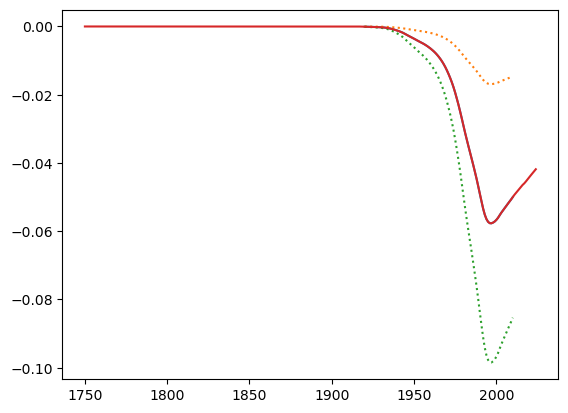

In [11]:
# Here fit only to AR5 2010 value
y = -0.05
ystd = 0.1/2.
neesc = eesc_newman.values
def sarffun(x):
    return x[0]*neesc*1e-8 
def min_func(x):
    mod = sarffun(x)
    return np.sum((mod[-1] - y)**2 / ystd**2) 
# res = minimize(min_func, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
res = minimize(min_func, [1], method='L-BFGS-B')



# Calculate second derivative of function min_func
def second_derivative(func, x0, epsilon=1e-8):
    """Compute the second derivative of a scalar function."""
    grad2 = approx_fprime(x0, approx_fprime(x0, func, epsilon))
    return grad2
xstd = np.sqrt(res.hess_inv  * np.identity(res.hess_inv.shape[1]))
print(res.x, xstd)

plt.plot(eesc_newman.index, sarffun(res.x), label=f"Fit")
plt.plot(eesc_newman.index, sarffun(res.x+xstd), ":" ,label=f"Fit")
plt.plot(eesc_newman.index, sarffun(res.x-xstd), ":", label=f"Fit")
plt.plot(df_out['forcing']['STRAT_O3'].dropna(), label="CICEROSCM")


Do same as above but for 2014 and adjustment to 2014 lifetime.
Thornhill et al. say that CH4 lifetime due to ODSs is -3.7 ± 2.4 % in 2014.
Let's say the same approach where it's a linear function of EESC

[-0.00298829] [[0.00137062]]


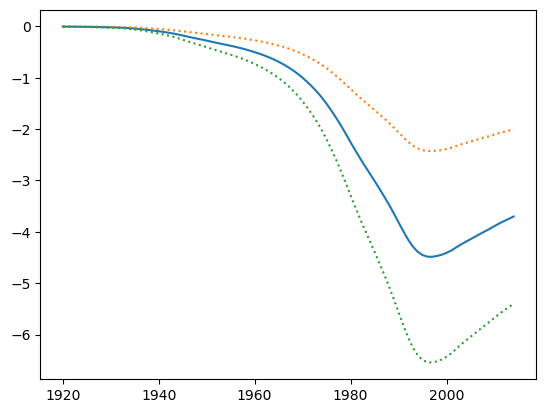

In [12]:
# Here fit only to AR5 2010 value
eesc_newman = (EESC_newman.sum(axis=1)-EESC_newman.loc[1750].sum()).loc['1920':'2014']#.values
y = -3.7
ystd = 2.4
neesc = eesc_newman.values
def ch4fun(x):
    return x[0]*neesc
def min_func(x):
    mod = ch4fun(x)
    return np.sum((mod[-1] - y)**2 / ystd**2) 
# res = minimize(min_func, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
res = minimize(min_func, [1], method='L-BFGS-B')

# Calculate second derivative of function min_func
xstd = np.sqrt(res.hess_inv  * np.identity(res.hess_inv.shape[1]))
print(res.x, xstd)

plt.plot(eesc_newman.index, ch4fun(res.x), label=f"Fit")
plt.plot(eesc_newman.index, ch4fun(res.x+xstd), ":" ,label=f"Fit")
plt.plot(eesc_newman.index, ch4fun(res.x-xstd), ":", label=f"Fit")


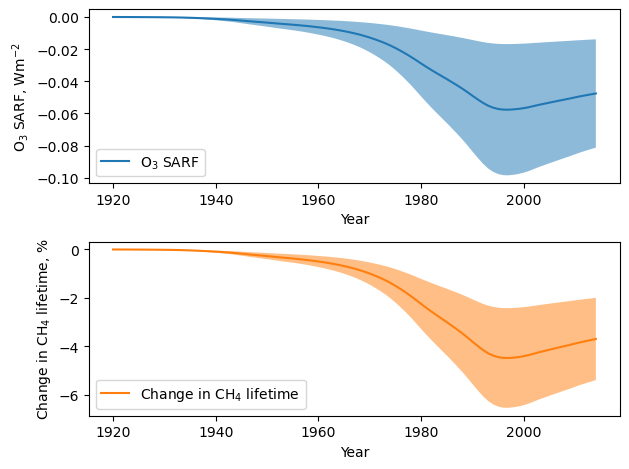

In [25]:
fig, ax = plt.subplots(2,1)

# Plot the first dataset
#[] [[2718.00075115]]
ax[0].set_ylabel('O$_3$ SARF, Wm$^{-2}$')
ax[0].set_xlabel("Year")
ax[0].plot(eesc_newman.index, sarffun([-3843.84159611]), label=f"O$_3$ SARF")
ax[0].fill_between(eesc_newman.index, sarffun([-3843.84159611-2718.00075115]), sarffun([-3843.84159611+2718.00075115]), alpha=0.5)
# ax1.tick_params(axis='O$_3$ SARF, Wm$^{-2}$')
ax[0].legend(loc="lower left")
# Create a second y-axis
# ax2 = ax1.twinx()
ax[1].set_ylabel("Change in CH$_4$ lifetime, %")
ax[1].plot(eesc_newman.index, ch4fun(res.x), label="Change in CH$_4$ lifetime", color="C1")
ax[1].fill_between(eesc_newman.index, ch4fun(res.x+xstd), ch4fun(res.x-xstd), 
                   alpha=0.5, facecolor="C1")
ax[1].set_xlabel("Year")
# ax2.tick_params(axis="Change in CH$_4$ lifetime, \%", labelcolor=color)
ax[1].legend(loc="lower left")
fig.tight_layout()
plt.show()

Optimization terminated successfully.
         Current function value: 0.002376
         Iterations: 56
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 0.001947
         Iterations: 58
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 0.023591
         Iterations: 56
         Function evaluations: 120


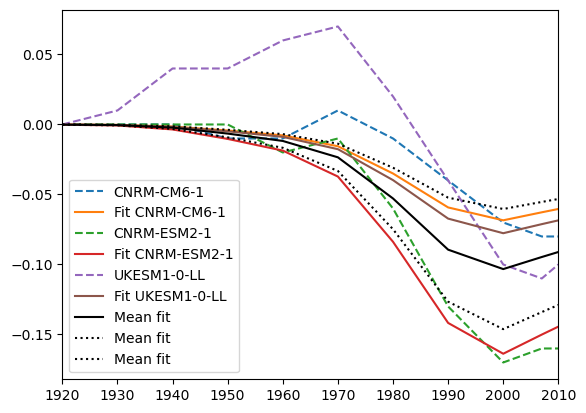

In [65]:
# for key in cmip6_data.keys():
#     if key == "years":
#         continue
#     plt.plot(cmip6_data["years"], np.array(cmip6_data[key])-cmip6_data[key][0], label=key, linestyle='--')

x_arr = []
for model in ["CNRM-CM6-1",	"CNRM-ESM2-1",	"UKESM1-0-LL"]:

    cmip6_mean = cmip6_df.mean(axis=1)
    # cmip6_var = cmip6_df.std(axis=1).values**2
    neesc = eesc_newman.loc[cmip6_mean.index].values
    # y = cmip6_mean.values - cmip6_mean.loc[1920]
    y = cmip6_df[model].values - cmip6_df[model].loc[1920]

    def sarffun(x):
        return x[0]*neesc*1e-8 
    def min_func(x):
        mod = sarffun(x)
        return np.sum((mod - y)**2) # / cmip6_var)
    
    x0 = np.array([1])
    res = minimize(min_func, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
    x_arr.append(res.x[0])
    plt.plot(cmip6_mean.index, y, label=f"{model}", linestyle='--')
    plt.plot(cmip6_mean.index, sarffun(res.x), label=f"Fit {model}")
plt.plot(cmip6_mean.index, sarffun(np.array([np.mean(x_arr)])), label=f"Mean fit", color="black")
plt.plot(cmip6_mean.index, sarffun(np.array([np.mean(x_arr)+np.std(x_arr)])), ":",label=f"Mean fit", color="black")
plt.plot(cmip6_mean.index, sarffun(np.array([np.mean(x_arr)-np.std(x_arr)])), ":",label=f"Mean fit", color="black")

# plt.plot(cmip6_mean.index, sarffun(np.array([-10000.9317])), label=f"Mean fit", color="yellow")
plt.xlim(1920,2010)
plt.legend()

In [66]:
print("Fit parameters:", np.mean(x_arr),np.std(x_arr))

Fit parameters: -7002.268052800505 2909.4701052346413


In [64]:
from scipy.optimize import approx_fprime

# Calculate second derivative of function min_func
def second_derivative(func, x0, epsilon=1e-8):
    """Compute the second derivative of a scalar function."""
    grad = approx_fprime(x0, func, epsilon)
    hessian = np.zeros((len(x0), len(x0)))
    for i in range(len(x0)):
        def partial_func(x):
            x_copy = x0.copy()
            x_copy[i] = x
            return approx_fprime(x_copy, func, epsilon)[i]
        hessian[i, i] = approx_fprime(np.array([x0[i]]), partial_func, epsilon)[0]
    return hessian

np.sqrt(-1/second_derivative(min_func, res.x))



/tmp/ipykernel_2956799/4021747794.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_copy[i] = x


array([[4.05831971]])

In [52]:
tau = 36.7
0.06+0.875*np.exp(-0.0114*tau)

0.6358480860175384